# HR Analytics

### Objective:
1. What are the key drivers that influence the candidate joining/not-joining a company?
2. Devising a predictive algorithm to calculate the probability of acceptance of an offer and joining the company after offer acceptance stage.

In [3]:
options(warn=-1)
library(dplyr)
library(lmtest) #For Likelihood ratio test
library(car)
library(DescTools) #For PseudoR-Square
library(ResourceSelection) #For Hosler Lemeshow Test
library(survey) #For Wald's Test
library(caret)
library(Deducer)  #for ROC plot
library(ROCR)     #for ROC plot (other way)


Attaching package: 'dplyr'

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union

Loading required package: zoo

Attaching package: 'zoo'

The following objects are masked from 'package:base':

    as.Date, as.Date.numeric


Attaching package: 'car'

The following object is masked from 'package:dplyr':

    recode


Attaching package: 'DescTools'

The following object is masked from 'package:car':

    Recode

ResourceSelection 0.3-2 	 2017-02-28
Loading required package: grid
Loading required package: Matrix
Loading required package: survival

Attaching package: 'survey'

The following object is masked from 'package:graphics':

    dotchart

Loading required package: lattice
Loading required package: ggplot2

Attaching package: 'caret'

The following object is masked from 'package:survival':

    cluster

The following object is masked from 'package:DescTools':

    RMSE

In [4]:
data <- read.csv("HR_Data_No_Missing_Value.csv",header = TRUE)
str(data)
summary(data)
dim(data)

'data.frame':	8995 obs. of  18 variables:
 $ SLNO                       : int  1 2 3 4 5 6 7 9 11 12 ...
 $ Candidate.Ref              : int  2110407 2112635 2112838 2115021 2115125 2117167 2119124 2127572 2138169 2143362 ...
 $ DOJ.Extended               : Factor w/ 2 levels "No","Yes": 2 1 1 1 2 2 2 2 1 1 ...
 $ Duration.to.accept.offer   : int  14 18 3 26 1 17 37 16 1 6 ...
 $ Notice.period              : int  30 30 45 30 120 30 30 0 30 30 ...
 $ Offered.band               : Factor w/ 4 levels "E0","E1","E2",..: 3 3 3 3 3 2 3 2 2 2 ...
 $ Pecent.hike.expected.in.CTC: num  -20.8 50 42.8 42.8 42.6 ...
 $ Percent.hike.offered.in.CTC: num  13.2 320 42.8 42.8 42.6 ...
 $ Percent.difference.CTC     : num  42.9 180 0 0 0 ...
 $ Joining.Bonus              : Factor w/ 2 levels "No","Yes": 1 1 1 1 1 1 1 1 1 1 ...
 $ Candidate.relocate.actual  : Factor w/ 2 levels "No","Yes": 1 1 1 1 2 1 1 1 1 1 ...
 $ Gender                     : Factor w/ 2 levels "Female","Male": 1 2 2 2 2 2 2 1 1 2 ...
 $ 

      SLNO       Candidate.Ref     DOJ.Extended Duration.to.accept.offer
 Min.   :    1   Min.   :2109586   No :4788     Min.   :  0.00          
 1st Qu.: 3208   1st Qu.:2386476   Yes:4207     1st Qu.:  3.00          
 Median : 5976   Median :2807482                Median : 10.00          
 Mean   : 5971   Mean   :2843647                Mean   : 21.43          
 3rd Qu.: 8739   3rd Qu.:3300060                3rd Qu.: 33.00          
 Max.   :12333   Max.   :3836076                Max.   :224.00          
                                                                        
 Notice.period    Offered.band Pecent.hike.expected.in.CTC
 Min.   :  0.00   E0: 211      Min.   :-68.83             
 1st Qu.: 30.00   E1:5568      1st Qu.: 27.27             
 Median : 30.00   E2:2711      Median : 40.00             
 Mean   : 39.29   E3: 505      Mean   : 43.86             
 3rd Qu.: 60.00                3rd Qu.: 53.85             
 Max.   :120.00                Max.   :359.77             
   

[1] 8995   18

In [5]:
#By default, the base category/reference category selected is ordered alphabetically. In this data set, Status has two classes (Joined/Not Joined). Since 'J' appears first compared to 'N' in alphabet sequence, So Joined will be marked as the base category.
#Changing the base category to "Not Joined" using Relevel()

data$Status <- relevel(data$Status , ref = "Not Joined")
summary(data)

      SLNO       Candidate.Ref     DOJ.Extended Duration.to.accept.offer
 Min.   :    1   Min.   :2109586   No :4788     Min.   :  0.00          
 1st Qu.: 3208   1st Qu.:2386476   Yes:4207     1st Qu.:  3.00          
 Median : 5976   Median :2807482                Median : 10.00          
 Mean   : 5971   Mean   :2843647                Mean   : 21.43          
 3rd Qu.: 8739   3rd Qu.:3300060                3rd Qu.: 33.00          
 Max.   :12333   Max.   :3836076                Max.   :224.00          
                                                                        
 Notice.period    Offered.band Pecent.hike.expected.in.CTC
 Min.   :  0.00   E0: 211      Min.   :-68.83             
 1st Qu.: 30.00   E1:5568      1st Qu.: 27.27             
 Median : 30.00   E2:2711      Median : 40.00             
 Mean   : 39.29   E3: 505      Mean   : 43.86             
 3rd Qu.: 60.00                3rd Qu.: 53.85             
 Max.   :120.00                Max.   :359.77             
   

In [6]:
#Create Training and Test Data-sets:
set.seed("2341")
trainIndex <- createDataPartition(data$Status,p=0.8,list = FALSE)
data.train <- data[trainIndex,]
data.test <- data[-trainIndex,]
dim(data.train)
dim(data.test)

[1] 7197   18

[1] 1798   18

## Stage 4: Estimating Regression Model and assessing overall model fit.
This stage includes:

4.1 Select method for specifying the Regression Model. This is done using Forward Selection - Backward Elimination
4.2 Assessing Overall Model Fit
    * Statistical Measures of Overall Model Fit:
        * Likelihood Ratio Test
        * Pseudo R-Square
        * Hosmer Lemeshow Goodness of Fit
    * Statistical Measures of Individual Variable:
        *Wald's Test
    * Model Acceptance:
        * Area under ROC Curve

In [7]:
#Null Model
noModel <- glm(Status ~ 1,data = data.train , family = binomial)

#Full Model
lgGlmModelFull = glm(Status ~ .
                     , data = data.train , family = binomial)

#Stepwise - Forward selection backward elimination
fit.stepwise <- step(noModel, list(lower = formula(noModel),
                                         upper = formula(lgGlmModelFull)), direction = "both",trace = 0)

summary(fit.stepwise)


Call:
glm(formula = Status ~ Candidate.relocate.actual + Notice.period + 
    LOB + Candidate.Source + Offered.band + Location + Age + 
    Percent.hike.offered.in.CTC + DOJ.Extended + Joining.Bonus + 
    Gender, family = binomial, data = data.train)

Deviance Residuals: 
     Min        1Q    Median        3Q       Max  
-2.68552   0.00012   0.50498   0.70347   1.55437  

Coefficients:
                                    Estimate Std. Error z value Pr(>|z|)    
(Intercept)                        1.503e+01  2.545e+03   0.006 0.995288    
Candidate.relocate.actualYes       1.728e+01  1.943e+02   0.089 0.929100    
Notice.period                     -2.078e-02  1.521e-03 -13.661  < 2e-16 ***
LOBBFSI                            5.113e-01  1.575e-01   3.247 0.001167 ** 
LOBCSMP                            4.018e-01  1.812e-01   2.218 0.026555 *  
LOBEAS                            -2.473e-01  1.954e-01  -1.266 0.205632    
LOBERS                             3.485e-01  1.489e-01   2.341 0.019

In [8]:
#Log Likelihood Ratio Test using anova()
anova(lgGlmModelFull,fit.stepwise,test ="Chisq")
#Since the p-value is greater than 0.05, we are unable to reject the Null Hypothesis, and accept the reduced model from stepwise regression

Resid. Df,Resid. Dev,Df,Deviance,Pr(>Chi)
7160,5968.796,NA,NA,NA
7166,5971.065,-6,-2.269392,0.8933311


In [9]:
#Pseudo R-Square measures
PseudoR2(fit.stepwise , which = "all")

McFadden     McFaddenAdj        CoxSnell      Nagelkerke   AldrichNelson 
      0.1391359       0.1301972       0.1254909       0.2028820       0.0391630 
VeallZimmermann          Effron McKelveyZavoina            Tjur             AIC 
      0.1728499       0.1197735       0.9205098       0.1185146    6033.0652739 
            BIC          logLik         logLik0              G2 
   6246.3892800   -2985.5326369   -3468.0648107     965.0643476

In [10]:
#Hosmer Lemeshow Goodness of Fit
hoslem.test(fit.stepwise$y,fitted(fit.stepwise))
#Since the p-value is greater than 0.05, we are unable to reject the Null Hypothesis, and accept the reduced model from stepwise regression


	Hosmer and Lemeshow goodness of fit (GOF) test

data:  fit.stepwise$y, fitted(fit.stepwise)
X-squared = 7.7415, df = 8, p-value = 0.4591


In [11]:
#Wald's Test for Significance of individual Parameters:
regTermTest(fit.stepwise,"Candidate.relocate.actual")
regTermTest(fit.stepwise,"Notice.period")
regTermTest(fit.stepwise,"LOB")
regTermTest(fit.stepwise,"Candidate.Source")
regTermTest(fit.stepwise,"Offered.band")
regTermTest(fit.stepwise,"Location")
regTermTest(fit.stepwise,"Age")
regTermTest(fit.stepwise,"Percent.hike.offered.in.CTC")
regTermTest(fit.stepwise,"Age")
regTermTest(fit.stepwise,"DOJ.Extended")
regTermTest(fit.stepwise,"Joining.Bonus")
regTermTest(fit.stepwise,"Gender")

Wald test for Candidate.relocate.actual
 in glm(formula = Status ~ Candidate.relocate.actual + Notice.period + 
    LOB + Candidate.Source + Offered.band + Location + Age + 
    Percent.hike.offered.in.CTC + DOJ.Extended + Joining.Bonus + 
    Gender, family = binomial, data = data.train)
F =  0.007916936  on  1  and  7166  df: p= 0.9291 

Wald test for Notice.period
 in glm(formula = Status ~ Candidate.relocate.actual + Notice.period + 
    LOB + Candidate.Source + Offered.band + Location + Age + 
    Percent.hike.offered.in.CTC + DOJ.Extended + Joining.Bonus + 
    Gender, family = binomial, data = data.train)
F =  186.6218  on  1  and  7166  df: p= < 2.22e-16 

Wald test for LOB
 in glm(formula = Status ~ Candidate.relocate.actual + Notice.period + 
    LOB + Candidate.Source + Offered.band + Location + Age + 
    Percent.hike.offered.in.CTC + DOJ.Extended + Joining.Bonus + 
    Gender, family = binomial, data = data.train)
F =  8.682801  on  8  and  7166  df: p= 7.2317e-12 

Wald test for Candidate.Source
 in glm(formula = Status ~ Candidate.relocate.actual + Notice.period + 
    LOB + Candidate.Source + Offered.band + Location + Age + 
    Percent.hike.offered.in.CTC + DOJ.Extended + Joining.Bonus + 
    Gender, family = binomial, data = data.train)
F =  20.27701  on  2  and  7166  df: p= 1.6544e-09 

Wald test for Offered.band
 in glm(formula = Status ~ Candidate.relocate.actual + Notice.period + 
    LOB + Candidate.Source + Offered.band + Location + Age + 
    Percent.hike.offered.in.CTC + DOJ.Extended + Joining.Bonus + 
    Gender, family = binomial, data = data.train)
F =  13.07836  on  3  and  7166  df: p= 1.6284e-08 

Wald test for Location
 in glm(formula = Status ~ Candidate.relocate.actual + Notice.period + 
    LOB + Candidate.Source + Offered.band + Location + Age + 
    Percent.hike.offered.in.CTC + DOJ.Extended + Joining.Bonus + 
    Gender, family = binomial, data = data.train)
F =  3.469044  on  10  and  7166  df: p= 0.0001446 

Wald test for Age
 in glm(formula = Status ~ Candidate.relocate.actual + Notice.period + 
    LOB + Candidate.Source + Offered.band + Location + Age + 
    Percent.hike.offered.in.CTC + DOJ.Extended + Joining.Bonus + 
    Gender, family = binomial, data = data.train)
F =  15.65867  on  1  and  7166  df: p= 7.6597e-05 

Wald test for Percent.hike.offered.in.CTC
 in glm(formula = Status ~ Candidate.relocate.actual + Notice.period + 
    LOB + Candidate.Source + Offered.band + Location + Age + 
    Percent.hike.offered.in.CTC + DOJ.Extended + Joining.Bonus + 
    Gender, family = binomial, data = data.train)
F =  6.643489  on  1  and  7166  df: p= 0.0099717 

Wald test for Age
 in glm(formula = Status ~ Candidate.relocate.actual + Notice.period + 
    LOB + Candidate.Source + Offered.band + Location + Age + 
    Percent.hike.offered.in.CTC + DOJ.Extended + Joining.Bonus + 
    Gender, family = binomial, data = data.train)
F =  15.65867  on  1  and  7166  df: p= 7.6597e-05 

Wald test for DOJ.Extended
 in glm(formula = Status ~ Candidate.relocate.actual + Notice.period + 
    LOB + Candidate.Source + Offered.band + Location + Age + 
    Percent.hike.offered.in.CTC + DOJ.Extended + Joining.Bonus + 
    Gender, family = binomial, data = data.train)
F =  6.429198  on  1  and  7166  df: p= 0.011247 

Wald test for Joining.Bonus
 in glm(formula = Status ~ Candidate.relocate.actual + Notice.period + 
    LOB + Candidate.Source + Offered.band + Location + Age + 
    Percent.hike.offered.in.CTC + DOJ.Extended + Joining.Bonus + 
    Gender, family = binomial, data = data.train)
F =  4.495086  on  1  and  7166  df: p= 0.034027 

Wald test for Gender
 in glm(formula = Status ~ Candidate.relocate.actual + Notice.period + 
    LOB + Candidate.Source + Offered.band + Location + Age + 
    Percent.hike.offered.in.CTC + DOJ.Extended + Joining.Bonus + 
    Gender, family = binomial, data = data.train)
F =  3.760255  on  1  and  7166  df: p= 0.052524 

Wald's test returns the result that the individual predictors: Candidate.relocate.actual & Gender are not significant.
So, we remove them from the regression model and compare the Log Likelihood Ratios

In [12]:
fit.reduced <- glm(formula = Status ~  Notice.period + 
    LOB + Candidate.Source + Offered.band + Location + Age + 
    Percent.hike.offered.in.CTC + DOJ.Extended + Joining.Bonus , family = binomial, data = data.train)
summary(fit.reduced)
anova(fit.stepwise , fit.reduced , test ="Chisq")


Call:
glm(formula = Status ~ Notice.period + LOB + Candidate.Source + 
    Offered.band + Location + Age + Percent.hike.offered.in.CTC + 
    DOJ.Extended + Joining.Bonus, family = binomial, data = data.train)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.7451   0.3498   0.5276   0.6845   1.4810  

Coefficients:
                                    Estimate Std. Error z value Pr(>|z|)    
(Intercept)                        11.424637 388.362885   0.029 0.976532    
Notice.period                      -0.020518   0.001443 -14.221  < 2e-16 ***
LOBBFSI                             0.267105   0.152142   1.756 0.079151 .  
LOBCSMP                             0.223772   0.174462   1.283 0.199618    
LOBEAS                             -0.289829   0.186495  -1.554 0.120164    
LOBERS                              0.261956   0.142499   1.838 0.066019 .  
LOBETS                              0.492559   0.171098   2.879 0.003992 ** 
LOBHealthcare                       0.340819

Resid. Df,Resid. Dev,Df,Deviance,Pr(>Chi)
7166,5971.065,NA,NA,NA
7168,6426.232,-2,-455.1672,1.451128e-99


Log-likelihood ratio test is significant. Thus the two models are not similar.
We cannot remove the variables. We proceed with the model from the Stepwise regression

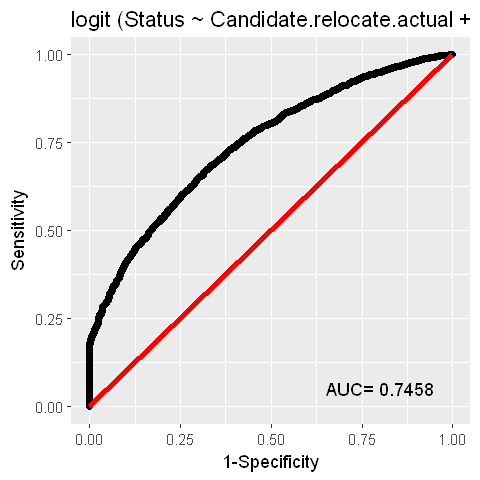

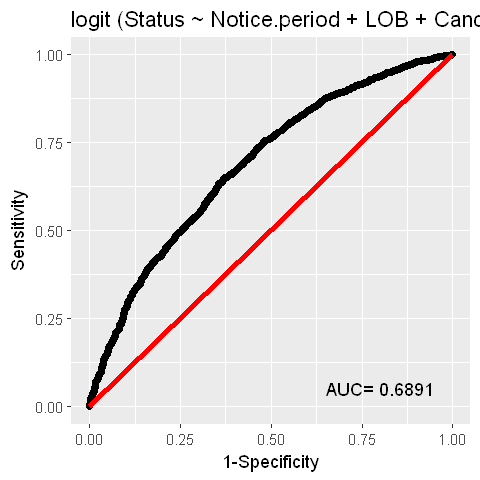

In [13]:
#Area uder ROC Curve:
options(repr.plot.width=4, repr.plot.height=4)
rocplot(fit.stepwise)
rocplot(fit.reduced)

In [14]:
#Computing the Cut-off Probability using Youden's Index:

#creating empty vectors to store the results. 
msclaf.cost <- c()
youden.index <- c()
cutoff <- c()
P11 <- c() #correct classification of positive as positive
P00 <- c() #correct classification of negative as negative
P10 <- c() #misclassification of positive class to negative class
P01 <- c() #misclassification of negative class to positive class

n <- length(data.train$Status)   #Sample Size
pred = predict.glm(fit.stepwise, data.train , type = "response")  #Predicted Probability as per Model

for (i in seq(0.05, 1, .05)) {
  predicted.y = rep("Joined", n)     #Assigning all predicted value as "No"
  predicted.y[pred > i] = "Not Joined"  #If predicted value greater than cut-off probability then changing the predicted to "Yes"
  tbl <- table(data.train$Status, predicted.y) #Creates Classification table based on the Cut-off probability i
  if ( i <= 1) {
    
    P10[20*i] <- tbl[2]/(tbl[2] + tbl[4])    
    P11[20*i] <- tbl[4]/(tbl[2] + tbl[4])   #Sensitivity
    P01[20*i] <- tbl[3]/(tbl[1] + tbl[3])    
    P00[20*i] <- tbl[1]/(tbl[1] + tbl[3])   #Specificity
    
    cutoff[20*i] <- i
    youden.index[20*i] <- P11[20*i] + P00[20*i] - 1
  }
}
youden.table <- cbind(cutoff,P10,P01,P11,P00, youden.index)

#Display the Youden's Index for each cut-off probability:
youden.table

cutoff,P10,P01,P11,P00,youden.index
0.05,NA,NA,NA,NA,NA
0.10,NA,NA,NA,NA,NA
0.15,NA,NA,NA,NA,NA
0.20,NA,NA,NA,NA,NA
0.25,NA,NA,NA,NA,NA
0.30,0.0003418219,0.998514116,0.9996582,0.001485884,0.001144062
0.35,0.0006836438,0.995542348,0.9993164,0.004457652,0.003774008
0.40,0.0015381986,0.979940565,0.9984618,0.020059435,0.018521237
0.45,0.0059818834,0.956166419,0.9940181,0.043833581,0.037851698
0.50,0.0126474107,0.919019316,0.9873526,0.080980684,0.068333273


### Accuracy of the model


In [30]:
i = 0.8 #Update with the Optimal Cut-off Probability

#Computing the Accuracy Manually:
n <- length(data.train$Status)   #Sample Size
pred = predict.glm(fit.stepwise, data.train , type = "response")  #Predicted Probability as per Model
predicted.y = rep("Joined", n)     #Assigning all predicted value as "No"
predicted.y[pred > i] = "Not Joined"  #If predicted value greater than cut-off probability then changing the predicted to "Yes"
accuracy <- table(predicted.y , data.train$Status) #Creates Classification table based on the Cut-off probability i
accuracy
sum(diag(accuracy))/sum(accuracy)

#Computing the Accuracy using the Confusion Matrix in Car Package:
confusionMatrix(data=predicted.y, data.train$Status)

            
predicted.y  Not Joined Joined
  Joined            954   2113
  Not Joined        392   3738

[1] 0.6519383

Confusion Matrix and Statistics

            Reference
Prediction   Not Joined Joined
  Not Joined        392   3738
  Joined            954   2113
                                          
               Accuracy : 0.3481          
                 95% CI : (0.3371, 0.3592)
    No Information Rate : 0.813           
    P-Value [Acc > NIR] : 1               
                                          
                  Kappa : -0.1935         
 Mcnemar's Test P-Value : <2e-16          
                                          
            Sensitivity : 0.29123         
            Specificity : 0.36113         
         Pos Pred Value : 0.09492         
         Neg Pred Value : 0.68895         
             Prevalence : 0.18702         
         Detection Rate : 0.05447         
   Detection Prevalence : 0.57385         
      Balanced Accuracy : 0.32618         
                                          
       'Positive' Class : Not Joined      
                                   

## Running the Model on Test Data

In [42]:
i = 0.8 #Update with the Optimal Cut-off Probability

#Computing the Accuracy Manually:
n <- length(data.test$Status)   #Sample Size
pred = predict.glm(fit.stepwise, data.test , type = "response")  #Predicted Probability as per Model
predicted.y = rep("Joined", n)     #Assigning all predicted value as "No"
predicted.y[pred > i] = "Not Joined"  #If predicted value greater than cut-off probability then changing the predicted to "Yes"
accuracy <- table(predicted.y , data.test$Status) #Creates Classification table based on the Cut-off probability i
accuracy
sum(diag(accuracy))/sum(accuracy)

#Computing the Accuracy using the Confusion Matrix in Car Package:
confusionMatrix(data=predicted.y, data.test$Status)

            
predicted.y  Not Joined Joined
  Joined            245    536
  Not Joined         91    926

[1] 0.6512792

Confusion Matrix and Statistics

            Reference
Prediction   Not Joined Joined
  Not Joined         91    926
  Joined            245    536
                                          
               Accuracy : 0.3487          
                 95% CI : (0.3267, 0.3713)
    No Information Rate : 0.8131          
    P-Value [Acc > NIR] : 1               
                                          
                  Kappa : -0.2036         
 Mcnemar's Test P-Value : <2e-16          
                                          
            Sensitivity : 0.27083         
            Specificity : 0.36662         
         Pos Pred Value : 0.08948         
         Neg Pred Value : 0.68630         
             Prevalence : 0.18687         
         Detection Rate : 0.05061         
   Detection Prevalence : 0.56563         
      Balanced Accuracy : 0.31873         
                                          
       'Positive' Class : Not Joined      
                                   

In [43]:
#Assesing Variable Importance:
varImp(fit.stepwise)

,Overall
Candidate.relocate.actualYes,8.897717e-02
Notice.period,1.366096e+01
LOBBFSI,3.246921e+00
LOBCSMP,2.217992e+00
LOBEAS,1.265668e+00
LOBERS,2.340977e+00
LOBETS,3.386569e+00
LOBHealthcare,2.183925e+00
LOBINFRA,5.872744e+00
LOBMMS,1.020416e-02
